In [1]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [4]:
print(tf.__version__)

2.13.0


# Explore data

In [5]:
# Please follow the link below to get the dataset into the google colab environment
# https://www.kaggle.com/discussions/general/74235

In [7]:
# first install kaggle library to utilize the API's to access kaggle datasets
! pip install -q kaggle

# then run the below built-in function to upload the "kaggle.json" to collab
from google.colab import files
files.upload()

# create a folder "kaggle" in the drive and copy the json file to that location
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

# change the permissions of the file
! chmod 600 ~/.kaggle/kaggle.json

# go to the page on kaggle, where you want to download the dataset
# In this case:- https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data
# copy the api command and run
! kaggle datasets download -d puneet6060/intel-image-classification

Saving kaggle.json to kaggle.json
 99% 343M/346M [00:11<00:00, 33.4MB/s]
100% 346M/346M [00:11<00:00, 31.0MB/s]


In [8]:
# As we can see we have the zip file, hence unzip using the following command
! mkdir intel-image
! ! unzip intel-image-classification.zip -d intel-image

Streaming output truncated to the last 5000 lines.
  inflating: intel-image/seg_train/seg_train/mountain/7506.jpg  
  inflating: intel-image/seg_train/seg_train/mountain/7537.jpg  
  inflating: intel-image/seg_train/seg_train/mountain/7539.jpg  
  inflating: intel-image/seg_train/seg_train/mountain/7551.jpg  
  inflating: intel-image/seg_train/seg_train/mountain/7560.jpg  
  inflating: intel-image/seg_train/seg_train/mountain/7565.jpg  
  inflating: intel-image/seg_train/seg_train/mountain/7578.jpg  
  inflating: intel-image/seg_train/seg_train/mountain/7581.jpg  
  inflating: intel-image/seg_train/seg_train/mountain/7586.jpg  
  inflating: intel-image/seg_train/seg_train/mountain/7647.jpg  
  inflating: intel-image/seg_train/seg_train/mountain/7652.jpg  
  inflating: intel-image/seg_train/seg_train/mountain/7654.jpg  
  inflating: intel-image/seg_train/seg_train/mountain/7662.jpg  
  inflating: intel-image/seg_train/seg_train/mountain/767.jpg  
  inflating: intel-image/seg_train/seg_t

In [11]:
import os

print("Train data: ")
for dirpath, dirnames, filenames in os.walk("image_intel/seg_train/seg_train"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
print("Test data: ")
for dirpath, dirnames, filenames in os.walk("image_intel/seg_test/seg_test"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
print("Prediction data: ")
for dirpath, dirnames, filenames in os.walk("image_intel/seg_pred/seg_pred"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

Train data: 
There are 6 directories and 0 images in 'image_intel/seg_train/seg_train'.
There are 0 directories and 2271 images in 'image_intel/seg_train/seg_train/forest'.
There are 0 directories and 2512 images in 'image_intel/seg_train/seg_train/mountain'.
There are 0 directories and 2404 images in 'image_intel/seg_train/seg_train/glacier'.
There are 0 directories and 2191 images in 'image_intel/seg_train/seg_train/buildings'.
There are 0 directories and 2382 images in 'image_intel/seg_train/seg_train/street'.
There are 0 directories and 2274 images in 'image_intel/seg_train/seg_train/sea'.
Test data: 
There are 6 directories and 0 images in 'image_intel/seg_test/seg_test'.
There are 0 directories and 474 images in 'image_intel/seg_test/seg_test/forest'.
There are 0 directories and 525 images in 'image_intel/seg_test/seg_test/mountain'.
There are 0 directories and 553 images in 'image_intel/seg_test/seg_test/glacier'.
There are 0 directories and 437 images in 'image_intel/seg_test/s

In [12]:
import random
import matplotlib.pyplot as plt
def view_random_image(target_dir, target_class):
  # We will view image from here
  target_folder = target_dir + target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder+'/'+random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off');
  print(f"Image shape {img.shape}")

  return img

Image shape (150, 150, 3)


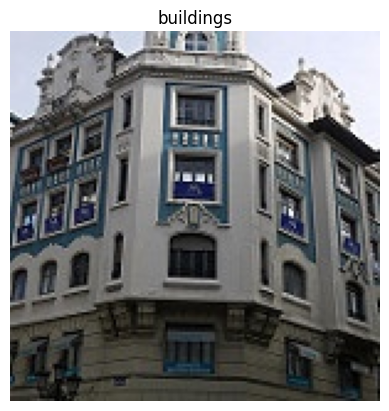

In [13]:
img = view_random_image(target_dir='image_intel/seg_train/seg_train/',
                  target_class='buildings')

In [14]:
# Get the class name programmatically
import pathlib
data_dir = pathlib.Path("image_intel/seg_train/seg_train")
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)


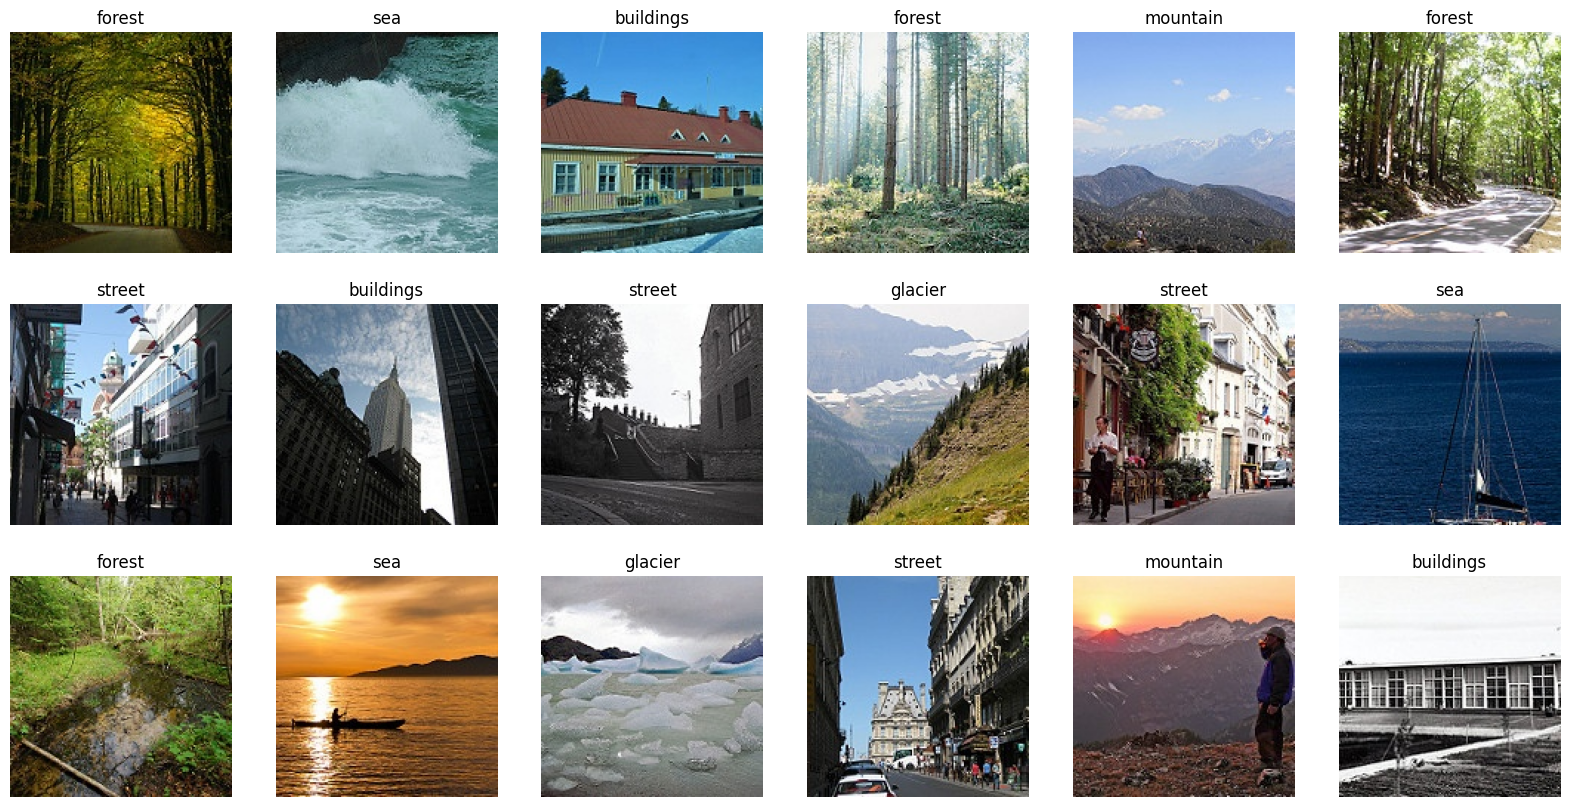

In [15]:
plt.figure(figsize=(20, 10))
for i in range(18):
  plt.subplot(3, 6, i+1)
  class_name = random.choice(class_names)
  img = view_random_image(target_dir='image_intel/seg_train/seg_train/',
                  target_class=class_name)

# Prepare data for model

In [16]:
train_dir = "image_intel/seg_train/seg_train/"
test_dir = "image_intel/seg_test/seg_test/"

In [17]:
# Create augmented data generator instance
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   rotation_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1/255.)

# Load data(data, label) from directory and turn them into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(150,150),
                                               batch_size=128,
                                               class_mode='categorical')
test_data = val_datagen.flow_from_directory(test_dir,
                                           target_size=(150,150),
                                           batch_size=128,
                                           class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# Basic model Buildinig (CNN Classifier)

In [18]:
model_1 = Sequential([
  Conv2D(16, 3, padding='same', activation='relu', input_shape=(150,150,3)),
  MaxPool2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(len(class_names), activation='softmax')
])

model_1.compile(loss="categorical_crossentropy",
              optimizer=Adam(),
              metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 64)        0

In [20]:
history_1 = model_1.fit(train_data,
                    epochs=5,
                    batch_size=128,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data))

Epoch 1/5
110/110 [==============================] - 101s 916ms/step - loss: 1.1406 - accuracy: 0.5546 - val_loss: 0.8705 - val_accuracy: 0.6687
Epoch 2/5
110/110 [==============================] - 93s 846ms/step - loss: 0.8315 - accuracy: 0.6880 - val_loss: 1.0840 - val_accuracy: 0.6097
Epoch 3/5
110/110 [==============================] - 94s 850ms/step - loss: 0.7485 - accuracy: 0.7264 - val_loss: 0.7274 - val_accuracy: 0.7323
Epoch 4/5
110/110 [==============================] - 94s 852ms/step - loss: 0.6795 - accuracy: 0.7480 - val_loss: 0.6583 - val_accuracy: 0.7533
Epoch 5/5
110/110 [==============================] - 93s 842ms/step - loss: 0.6418 - accuracy: 0.7660 - val_loss: 0.7143 - val_accuracy: 0.7390


In [21]:
model_1.evaluate(test_data)

24/24 [==============================] - 3s 141ms/step - loss: 0.7143 - accuracy: 0.7390


[0.7143465280532837, 0.7390000224113464]

# Training Validation Analysis

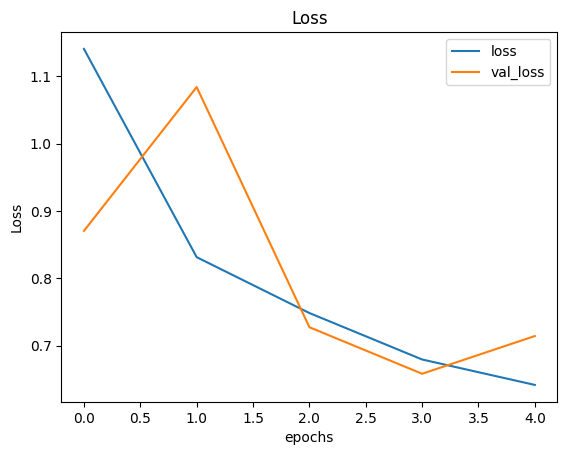

In [22]:
pd.DataFrame(history_1.history)[['loss','val_loss']].plot()
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss');

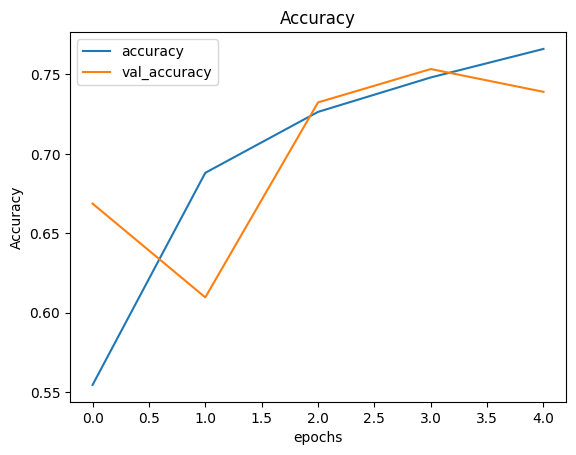

In [23]:
pd.DataFrame(history_1.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy');

# Conclusion

In [24]:
model_1.save('/content/drive/MyDrive/image_intel/models/', save_format='tf')

In [25]:
!ls -alrt /content/drive/MyDrive/image_intel/models/

total 192
drwx------ 2 root root   4096 Oct  8 22:56 variables
-rw------- 1 root root 167254 Oct  8 22:56 saved_model.pb
-rw------- 1 root root  20230 Oct  8 22:56 keras_metadata.pb
-rw------- 1 root root     55 Oct  8 22:56 fingerprint.pb
drwx------ 2 root root   4096 Oct  8 22:56 assets


In [26]:
model_loaded = tf.keras.models.load_model('/content/drive/MyDrive/image_intel/models/')

In [27]:
model_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 64)        0

In [28]:
from PIL import Image
import numpy as np
from skimage import transform
def process(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')
   np_image = transform.resize(np_image, (150, 150, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

In [29]:
# Finally zip the file and download for reference
!zip -r models.zip /content/drive/MyDrive/image_intel/models/

  adding: content/drive/MyDrive/image_intel/models/ (stored 0%)
  adding: content/drive/MyDrive/image_intel/models/variables/ (stored 0%)
  adding: content/drive/MyDrive/image_intel/models/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/drive/MyDrive/image_intel/models/variables/variables.index (deflated 63%)
  adding: content/drive/MyDrive/image_intel/models/assets/ (stored 0%)
  adding: content/drive/MyDrive/image_intel/models/fingerprint.pb (stored 0%)
  adding: content/drive/MyDrive/image_intel/models/saved_model.pb (deflated 87%)
  adding: content/drive/MyDrive/image_intel/models/keras_metadata.pb (deflated 91%)
